In [1]:
import pandas as pd
from prophet import Prophet

/home/rupeshr/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def train_test_split(data, train_ratio):
    len_data = len(data)
    train_size = int(len_data * train_ratio)
    train, test = data[0:train_size], data[train_size:len_data]
    return train, test

In [3]:
def fb_prophet(*,data, date_col, target_col, exog_col=None, custom_seasonalities=None,country_based_holidays=None,ratio, freq, future_period):
    try:
        if exog_col == None:
            data=data[[date_col,target_col]]
        else:
            data=data[[date_col,target_col, exog_col]]
        
        data[date_col]=pd.to_datetime(data[date_col])    
        
        train, test = train_test_split(data, ratio)
        
        m = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=10,seasonality_mode='multiplicative')
        
        if custom_seasonalities ==None:
            pass
        else:
            print('Adding Custom Seasonalities')
            custom_seasonalities=custom_seasonalities
            m.add_seasonality(name=custom_seasonalities[0], period=custom_seasonalities[1], fourier_order=custom_seasonalities[2])
        
        if country_based_holidays ==None:
            pass
        else:
            print('Adding Holiday Region')
            m.add_country_holidays(country_name=country_based_holidays)
     
        if exog_col ==None:
            pass
        else:
            print('Adding Regressor')
            if len(exog_col)==1: 
                m.add_regressor(exog_col)
            elif len(exog_col) >1 and len(exog_col)==2: #maximum 2
                m.add_regressor(exog_col[0])
                m.add_regressor(exog_col[1])
            else:
                print("kindly use less or equal to 2 variables in exog field")
                   
        m.fit(train)
        pred = m.make_future_dataframe(periods=len(test), freq=freq,include_history=False)
        prediction = m.predict(pred)
        fut=m.make_future_dataframe(periods=len(test)+future_period,freq=freq,include_history=False)
        future=m.predict(fut)
        future = future[len(test):]
        return train, test, prediction, future
    except Exception as e:
        print(e)
        return

In [6]:
data = pd.read_csv('/home/rupeshr/Desktop/TSA_Python/dataset/data_new/06-07/sales-cars.csv')
data.rename(columns = {"Month": "ds",'Sales':'y'}, inplace=True)
date_col='ds'
target_col='y'
exog_col=None
custom_seasonalities=None #['quarterly',4,10]
country_based_holidays= None'US'
ratio =0.90
freq='MS'
future_period=5
train, test, prediction, future=fb_prophet(data=data, date_col=date_col, target_col=target_col,exog_col=exog_col, custom_seasonalities=custom_seasonalities,country_based_holidays=country_based_holidays,ratio=ratio, freq=freq, future_period=future_period)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.


Adding Custom Seasonalities
Adding Holiday Region


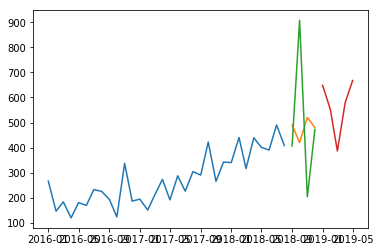

In [7]:
train.set_index('ds', inplace=True)
test.set_index('ds', inplace=True)
prediction.set_index('ds', inplace=True)
future.set_index('ds', inplace=True)
import matplotlib.pyplot as plt
plt.plot(train['y'])
plt.plot(test['y'])
plt.plot(prediction['yhat'])
plt.plot(future['yhat'])
plt.show()

In [ ]:
#saving model using json instead of pickel ...
'''
In Python, models should not be saved with pickle; the Stan backend attached to the model 
object will not pickle well, and will produce issues under certain versions of Python. 
Instead, you should use the built-in  serialization functions to serialize the model to json:'''

In [ ]:
import json
from prophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    json.dump(model_to_json(m), fout)  # Save model

with open('serialized_model.json', 'r') as fin:
    m = model_from_json(json.load(fin))  # Load model